In [46]:
#Import the libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics
from nltk.stem import WordNetLemmatizer

import re
import pandas as pd
import seaborn as sns
import spacy
import nltk
import string
nltk.download('punkt')
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Semiu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [47]:
#Initialize WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

In [48]:
#Function to extract the text (CVE descriptions)
def extract_text_corpus():
    
    cve_text_corpus = []
    
    java_cve_text = pd.read_csv("C:\\Users\\Semiu\\Documents\\java-codesecurity\\JavaVulData\\JavaVulData.csv")
    
    for cve in java_cve_text['vulnerability_description']:
        #Little pre-processing
        cve_pre1 = re.split("CVSS", cve)
        cve_pre2 = re.split("/", cve_pre1[0])
        final_cve = cve_pre2[0].replace('\n','')
        cve_text_corpus.append(final_cve)
        
    return cve_text_corpus

In [49]:
#extract_text_corpus return list to a variable
list_of_CVEs = extract_text_corpus()

In [59]:
list_of_CVEs

['Deserialization of untrusted data in the login page of ASSUWEB 359.3 build 1 subcomponent of ACA ASSUREX RENTES product allows a remote attacker to inject unsecure serialized Java object using a specially crafted HTTP request, resulting in an unauthenticated remote code execution on the server.',
 'Vulnerability in the Java VM component of Oracle Database Server. Supported versions that are affected are 12.1.0.2, 12.2.0.1, 18c and 19c. Difficult to exploit vulnerability allows low privileged attacker having Create Session privilege with network access via Oracle Net to compromise Java VM. Successful attacks require human interaction from a person other than the attacker. Successful attacks of this vulnerability can result in unauthorized creation, deletion or modification access to critical data or all Java VM accessible data. ',
 'An issue was discovered in UNCTAD ASYCUDA World 2001 through 2020. The Java RMI Server has an Insecure Default Configuration, leading to Java Code Executi

In [50]:
#Create stop words from fundamental English stop words
stopwords = set(w.rstrip() for w in open(r'C:\Users\Semiu\Documents\java-codesecurity\text-classification-CVE-Commits\stopwords.txt'))

# Add more stopwords specific to this problem - as seen in the raw data
#This was iterately expanded
stopwords = stopwords.union({
    'java', 'se', 'vulnerability', 'sdk', 'remote', 'oracle', 'database', 'server', 'attacker', 'sap', 'netweaver', 'android',
'ibm', 'embedded', 'product', 'solution', 'manager', 'xstream', 'allows', 'an', 'unauthenticated', 'component', 'issue',
'discovered', 'noise', 'apache', 'xwiki', 'junit', 'discovered', 'unsafe', 'code', 'netscape', 'microsoft', 'machine', 'virtual',
'bea', 'navigator', 'serversocket', 'weblogic', 'vm', 'development', 'kit', 'jre', 'unspecified', 'unknown', 'sun', 'runtime', 
'environment', 'and', '2d', 'web', 'confidentiality', 'integrity', 'unknown', 'vectors', 'products', 'suite', 'in', 'the', 'availability',
'update', 'mobile', 'cicso', 'mobility', 'tomcat', 'update', 'in', 'earlier', 'openjdk', 'red', 'hat', 'related', 'postgresql', 'netflix',
'issue','deployment', 'attack', 'version', 'compromise', 'i', 'sandbox', 'sandboxed', 'this', 'result', 'affect', 'via', '',
'security', 'service', 'refresh', 'internet', 'access', 'vector', 'cv', 'base', 'score', 'data', 'apis', 'network', 'running',
'applets'})

In [51]:
#Tokenization and Text pre-processing function
def my_tokenizer(s):
    s = s.lower() # downcase
    tokens = nltk.tokenize.word_tokenize(s) # split string into words (tokens)
    tokens = [t for t in tokens if len(t) > 2 or len(t)==1]   # remove short words, they're probably not useful
    tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens] # put words into base form
    tokens = [t for t in tokens if t not in stopwords] # remove stopwords
    tokens = [t for t in tokens if not any(c.isdigit() for c in t)] # remove any digits, i.e. "7.0"
    return tokens

In [52]:
#Tokenize each of the CVEs in the list_of_CVEs
def cve_to_tokens():
    all_tokens = []
    for java_cve in list_of_CVEs:
        try:
            java_cve = java_cve.encode('ascii', 'ignore') # this will throw exception if bad characters
            java_cve = java_cve.decode('utf-8')
            tokens = my_tokenizer(java_cve) #Call the my_tokenizer function for each cve in the list_of_CVEs
            all_tokens.append(tokens)
        except Exception as e:
            print(e)
    return all_tokens

In [53]:
list_of_tokens = cve_to_tokens()

In [54]:
new_sentence = []
for token_list in list_of_tokens:
    concatenate_token = " "
    for token in token_list:
        concatenate_token += " " +token
    new_sentence.append(concatenate_token)

In [55]:
#Function to concantenate the list of CVE to a string
def concatenate_cve (new_sentence):
    concatenated_cve = " "
    for cve in new_sentence:
        concatenated_cve += " " +cve
    return concatenated_cve

In [56]:
# Load Spacy.io's pre-trained model for English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_lg")

# Process the pre-processed document
text = (concatenate_cve (new_sentence))
doc = nlp(text)

# Analyze syntax
vulnerability_phrases = [chunk.text for chunk in doc.noun_chunks]

In [57]:
#Convert the vulnerabilities phrases/entities to data frame
vul_phrases_df = pd.DataFrame(vulnerability_phrases,columns=["vulnerability_phrases"])

C:\Users\Semiu\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


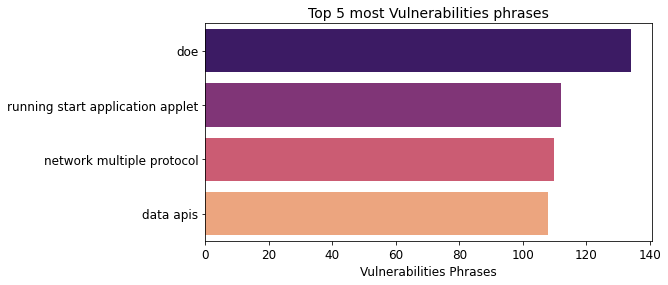

In [58]:
# Top 5 vulnerabilities phrases
fig, ax = plt.subplots(figsize = (8,4))
sns.barplot(vul_phrases_df['vulnerability_phrases'].value_counts()[1:5].values, vul_phrases_df['vulnerability_phrases'].value_counts()[1:5].index, palette=('magma'));
# customization
plt.xlabel('Vulnerabilities Phrases',fontsize=12)
plt.xticks(size=12)
plt.yticks(size=12)
plt.title('Top 5 most Vulnerabilities phrases',size=14)
plt.show();

In [ ]:
#Initialize a vectorizer from the TFIDF
vectorizer = TfidfVectorizer(stop_words='english')

vectorized_corpus = vectorizer.fit_transform(extract_text_corpus())